Make all the imports:

In [15]:
# Uncomment if you need to download these packages
# !pip install neptune
# !pip install neptune torch torchvision

import neptune
import urllib.request
import zipfile
import os
import fileinput

#  imports for the network
import torchvision, torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
from sklearn.metrics import confusion_matrix

import time

In [8]:
# prepare neptune

run = neptune.init_run(
    project="FLAME-SCOUT/FLAME-SCOUT",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4MGI4ZWI5Zi1kZjBhLTQ3YzQtYjU0Yy03NTMxMjhmNWZhYjYifQ==",
)  # your credentials

parameters = {
    "activation": "relu",
    "dropout": 0.5,
    "batch_size": 32,
    "n_epochs": 50,
    "momentum": 0.1
}
run["model/parameters"] = parameters

https://app.neptune.ai/FLAME-SCOUT/FLAME-SCOUT/e/FLAM-2


Download the Dataset for Classification:

In [3]:
# Get files in current working directory
files = os.listdir()

if 'Dataset' not in files:

  # This url points to the download of the .zip file for the full classification training
  # url = 'https://www.dropbox.com/scl/fi/9sxb3s88hw2zr2f0bbvf9/Dataset.zip?rlkey=8s4bobjz0b7ee68vjt384cjk1&dl=1'

  # This url points to the download of the .zip file for the edited classification training
  url = 'https://www.dropbox.com/scl/fi/8agmlcmfwezfyi4rjq631/Dataset.zip?rlkey=gvhl191glm8tmevv6e375lp2d&dl=1'


  # Download the zip file
  u = urllib.request.urlopen(url)
  data = u.read()
  u.close()

  # Specify the local filename for the downloaded zip file
  zip_filename = 'Dataset.zip'

  with open(zip_filename, 'wb') as f:
      f.write(data)

  # Unzip the downloaded file
  with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
      # Extract all contents to the current working directory
      zip_ref.extractall()

Preprocessing and examination:

Length of the Training set: 31500
Length of the Validation set: 7875
Length of the Testing set: 8617


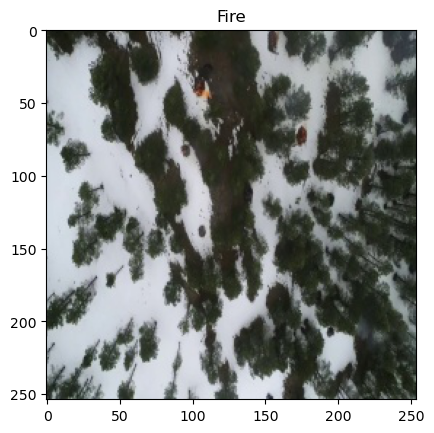

In [4]:
# Get the current folder paths of the dataset
Training_path = 'Dataset/Classification/Training'
Testing_path = 'Dataset/Classification/Test'

# Create the datasets
transform = transforms.Compose([transforms.ToTensor()])
training_dataset = torchvision.datasets.ImageFolder(Training_path, transform=transform)
testing_dataset = torchvision.datasets.ImageFolder(Testing_path, transform=transform)

# Split the training data (80%)
training_len = len(training_dataset.samples)
val_split = 0.2
val_len = int(val_split * training_len )
training_len -= val_len
training_dataset, validation_dataset = torch.utils.data.random_split(training_dataset, [training_len , val_len])

# Create the dataloaders
batch_size_training = 32
training_loader = DataLoader(training_dataset,batch_size=batch_size_training,shuffle=True,num_workers=0)

batch_size_validation = 32
validation_loader = DataLoader(validation_dataset,batch_size=batch_size_training,shuffle=True,num_workers=0)

batch_size_testing = 32
testing_loader = DataLoader(testing_dataset,batch_size=batch_size_testing,shuffle=True,num_workers=0)

print('Length of the Training set: '+str(len(training_dataset)))
print('Length of the Validation set: '+str(len(validation_dataset)))
print('Length of the Testing set: '+str(len(testing_dataset)))

map = {0:'Fire', 1:'No Fire'}

# Print one image
dataiter = iter(training_loader)
images, labels = next(dataiter)

for image, label in zip(images, labels):
    plt.figure()
    plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
    plt.title(map[label.item()])
    break


Define the Model:

In [5]:
class FLAME_SCOUT_Model(nn.Module):
    def __init__(self, num_classes):
        super(FLAME_SCOUT_Model, self).__init__()

        # Initial Convolutional Block
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(8)

        # Separable Convolution Blocks with Residual Connections
        self.conv_blocks = self._make_conv_blocks(8)

        # 1x1 Convolution for Residual Connection
        self.conv_residual = nn.Conv2d(8, 8, kernel_size=1, stride=1, padding=0)  # Adjusted stride

        # Final Convolutional Block
        self.final_conv = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.bn_final = nn.BatchNorm2d(8)

        # Global Average Pooling and Output Layer
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(8, num_classes)

    def _make_conv_blocks(self, size):
        return nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(size, size, kernel_size=3, padding=1),
            nn.BatchNorm2d(size),
            nn.ReLU(),
            nn.Conv2d(size, size, kernel_size=3, padding=1),
            nn.BatchNorm2d(size),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        previous_block_activation = x

        for block in self.conv_blocks:
            x = block(x)
            # Use 1x1 convolution for residual connection
            residual = self.conv_residual(previous_block_activation)
            residual = F.interpolate(residual, size=x.size()[2:], mode='nearest')  # Adjusted to match the spatial dimensions
            x = x + residual
            previous_block_activation = x

        x = F.relu(self.bn_final(self.final_conv(x)))

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

In [12]:
def train_pytorch_model(model, train_loader, val_loader, criterion, optimizer, epochs, device, save_model_flag=False):

    for epoch in range(epochs):
        epoch_start_time = time.time()  # Record the start time of the epoch

        #Initialize Accuracy Values
        training_loss=0
        correct = 0
        total = 0
        
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            training_loss += loss.item()
            run["train/batch/loss"].append(loss)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            batch_number = total/32
            if batch_number % 100 ==0:
              print("This is batch {} of epoch {}".format(batch_number,epoch+1))

        training_loss /= len(train_loader)
        training_accuracy = correct / total
        run["valid/acc"] = correct / total

        model.eval()

        # Save the model after training 1 epoch
        if save_model_flag:
          torch.save(model.state_dict(), "pytorch_model_{}.pth".format(epoch+1))

        with torch.no_grad():
            val_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        accuracy = correct / total
        epoch_end_time = time.time()  # Record the end time of the epoch
        epoch_time = epoch_end_time - epoch_start_time  # Calculate the time taken for the epoch
        epoch_time_str = "{:0>2}:{:05.2f}".format(int(epoch_time // 60), epoch_time % 60)
 
    
        
        file_path = 'output.txt'
        with open(file_path, 'a') as file:
            # Assuming you have the variables epoch, epochs, training_loss, training_accuracy, val_loss, and accuracy defined
            content = f"Epoch [{epoch+1}/{epochs}] ({epoch_time_str})- Training Loss: {training_loss:.4f} - Training Accuracy: {100 * training_accuracy:.2f}% - Validation Loss: {val_loss:.4f} - Validation Accuracy: {100 * accuracy:.2f}%"

            # Print the content to the console
            print(content)

            # Write the content to the file
            print(content, file=file)

# Create an instance of the model
num_classes = 2
input_shape = (3, 254, 254)
model = FLAME_SCOUT_Model(num_classes)

# Print the model architecture
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Define number of epochs
epochs = 50

# Move the model to the device
model = nn.DataParallel(model)
model = model.to(device)

# Train the model
train_pytorch_model(model, training_loader, validation_loader, criterion, optimizer, epochs, device, save_model_flag=True)

run["model/parameters/n_epochs"] = epochs

FLAME_SCOUT_Model(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_blocks): Sequential(
    (0): ReLU()
    (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv_residual): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1))
  (final_conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_final): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avg_pool): AdaptiveAvgPool2d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in

In [18]:
def evaluate(model, test_loader, epoch):
    model.eval()
    correct = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nEpoch {} Test Accuracy: {}/{} ({:.2f}%)\n'.format(epoch, correct, len(test_loader.dataset), accuracy))

    return all_preds, all_targets, accuracy

In [19]:
def add_text_to_line(file_path, line_number, text_to_add):
    with fileinput.FileInput(file_path, inplace=True, backup='.bak') as file:
        for i, line in enumerate(file, start=1):
            if i == line_number:
                print(line.rstrip() + text_to_add)
            else:
                print(line, end='')


Epoch 1 Test Accuracy: 7113/8617 (82.55%)



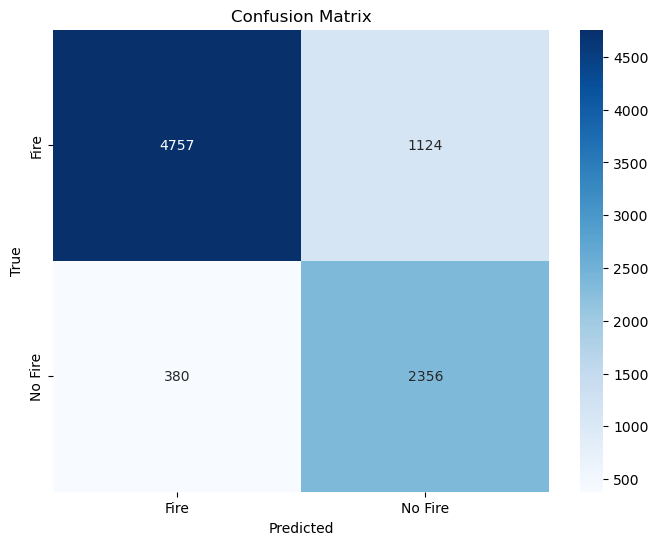

NameError: name 'run' is not defined

In [22]:
# Get files in current working directory
files = os.listdir()

# Check the dataset and the model are present in the files
if 'Dataset' in files:
    for i in range(1, epochs+1):
        model_path = "pytorch_model_{}.pth".format(i)
            
        if model_path in files :
            # Load the model
            model = FLAME_SCOUT_Model(num_classes=2)
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

            # If the model was saved with DataParallel, remove the 'module' prefix from keys
            state_dict = torch.load(model_path, map_location=device)
            if 'module' in list(state_dict.keys())[0]:
                state_dict = {k[7:]: v for k, v in state_dict.items()}

            model.load_state_dict(state_dict)

            # Do the Testing
            all_targets, all_preds, accuracy= evaluate(model, testing_loader, i)

            # Add the accuracy to the README.md file
            file_path = 'README.md'
            line_number = i  # Specify the line number where you want to add text
            text_to_add = f" - Test Accuracy: {accuracy:.2f}%"
            add_text_to_line(file_path, line_number, text_to_add)

    # Calculate confusion matrix for the last iteration
    cm = confusion_matrix(all_targets, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fire", "No Fire"], yticklabels=["Fire", "No Fire"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()    

# Dataset or Model weren't found
else:
    print("Dataset or Model not found. Please download the dataset and unzip it to the current working directory.")
    
run.stop()